In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import heapq

In [2]:
size = (30, 50)
obstacles = [(5, 5, 10, 10), (20, 30, 25, 45), (15, 0, 20, 5)]
start = (0, 0)
goal = (29, 40)

In [3]:
class Node:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.parent_node = None

In [4]:
def is_within_obstacles(point, obstacles):
  for (ox, oy, ex, ey) in obstacles:
    if ox <= point[0] <= ex and oy <= point[1] <= ey:
      return True
  return False

def distance(point1, point2):
  return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def nearest_node(nodes, random_point):
  return min(nodes, key=lambda node: distance((node.x, node.y), random_point))

def steer(from_node, to_point, step_size=1):
  if distance((from_node.x, from_node.y), to_point) < step_size:
    return Node(to_point[0], to_point[1])
  else:
    theta = np.arctan2(to_point[1] - from_node.y, to_point[0] - from_node.x)
    return Node(from_node.x + step_size * np.cos(theta), from_node.y + step_size * np.sin(theta))

""" Check if the path between node1 and node2 is valid by interpolating points along the way. """
def is_valid_path(node1, node2, obstacles):
  steps = int(distance((node1.x, node1.y), (node2.x, node2.y)) / 0.5)  # Smaller steps for more accuracy
  # print("Node1:", node1.x, node1.y)
  # print("Node2:", node2.x, node2.y)
  # print(steps)
  for i in range(1, steps + 1):
    inter_x = node1.x + i * (node2.x - node1.x) / steps
    inter_y = node1.y + i * (node2.y - node1.y) / steps
    # print(inter_x, inter_y)
    if is_within_obstacles((inter_x, inter_y), obstacles):
      return False
  return True


def plot(nodes=None, path=None):
    fig, ax = plt.subplots()
    if nodes:
      for node in nodes:
          if node.parent_node:
              plt.plot([node.x, node.parent_node.x], [node.y, node.parent_node.y], "g-", linewidth=0.5)
    for (ox, oy, ex, ey) in obstacles:
        ax.add_patch(plt.Rectangle((ox, oy), ex - ox, ey - oy, color="red"))
    if path:
        plt.plot([node.x for node in path], [node.y for node in path], "b-", linewidth=2)  # Highlight path in blue
    plt.plot(start[0], start[1], "bo")  # Start
    plt.plot(goal[0], goal[1], "ro")  # Goal
    plt.grid(True)
    plt.show()

In [5]:
def rrt(start, goal, size, obstacles, step_size=5, max_nodes=10000):
    nodes = [Node(start[0], start[1])]
    while len(nodes) < max_nodes:
        random_point = (random.randint(0, size[0] - 1), random.randint(0, size[1] - 1))
        if is_within_obstacles(random_point, obstacles):
            continue
        nearest = nearest_node(nodes, random_point)
        new_node = steer(nearest, random_point, step_size)
        if not is_within_obstacles((new_node.x, new_node.y), obstacles) and is_valid_path(nearest, new_node, obstacles):
            new_node.parent_node = nearest
            nodes.append(new_node)
            if distance((new_node.x, new_node.y), goal) <= 2:#step_size:
                return nodes, new_node
    return nodes, None  # Return None if max_nodes reached without finding a path

In [6]:
def create_initial_population(population_size=10, start=(0,0), goal=(29, 40) ,plot_paths = False):
  population = []
  # solution = []
  for i in range(population_size):
    nodes, final_node = rrt(start, goal, size, obstacles)
    path = []
    if final_node:
        while final_node.parent_node:
            path.append(final_node)
            final_node = final_node.parent_node
        path.append(final_node)
        path.reverse()
    if plot_paths:
      print(path)
      plot(nodes, path)
    # if path:
    #     solution.clear()
    #     # print("Path waypoints:")
    #     for node in path:
    #         # print(f"({node.x}, {node.y})")
    #         solution.append((node.x, node.y))
    # else:
    #     print("No path found.")
    population.append(path)
  return population

In [7]:
def fitness_function(path):
    coordinates = [(node.x, node.y) for node in path]
    wt = 2
    euc_dist = 0
    for i in range(len(coordinates) - 1):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i+1]
        dist_ = math.sqrt((x2-x1)**2 +(y2-y1)**2)
        euc_dist += dist_
        if euc_dist > 0:
            F = 1 / (wt*euc_dist)
        else:
            F = float('inf')
    return euc_dist, F

def print_path(path):
  coordinates = [(node.x, node.y) for node in path]
  print(coordinates)

[<__main__.Node object at 0x7feb31512020>, <__main__.Node object at 0x7feb31512b00>, <__main__.Node object at 0x7feb31512bc0>, <__main__.Node object at 0x7feb31511480>, <__main__.Node object at 0x7feb315134c0>, <__main__.Node object at 0x7feb31512cb0>, <__main__.Node object at 0x7feb31512c20>, <__main__.Node object at 0x7feb31510910>, <__main__.Node object at 0x7feb31511090>, <__main__.Node object at 0x7feb315115a0>, <__main__.Node object at 0x7feb315127a0>, <__main__.Node object at 0x7feb31510c10>, <__main__.Node object at 0x7feb31503df0>, <__main__.Node object at 0x7feb315032b0>, <__main__.Node object at 0x7feb31501750>, <__main__.Node object at 0x7feb31504e20>, <__main__.Node object at 0x7feb31505c60>, <__main__.Node object at 0x7feb314d6470>]


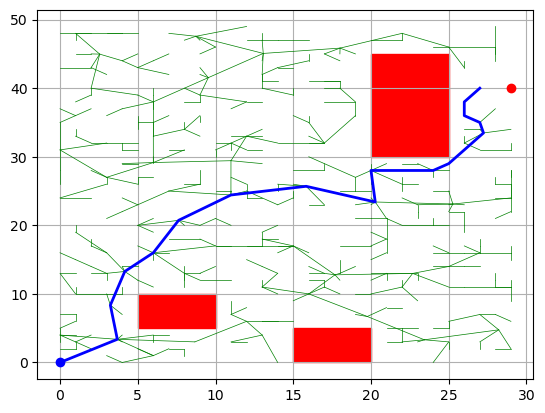

[<__main__.Node object at 0x7feb314d7e20>, <__main__.Node object at 0x7feb314d6dd0>, <__main__.Node object at 0x7feb2efafb20>, <__main__.Node object at 0x7feb314d6c50>, <__main__.Node object at 0x7feb2efaff40>, <__main__.Node object at 0x7feb2efaff70>, <__main__.Node object at 0x7feb2efec370>, <__main__.Node object at 0x7feb2f025c60>, <__main__.Node object at 0x7feb2eeb1b10>, <__main__.Node object at 0x7feb2eeb1b70>, <__main__.Node object at 0x7feb2eeb1c90>, <__main__.Node object at 0x7feb2eeb1de0>, <__main__.Node object at 0x7feb2eeb1e70>, <__main__.Node object at 0x7feb2eefb340>, <__main__.Node object at 0x7feb2eefb6d0>, <__main__.Node object at 0x7feb2ef481c0>, <__main__.Node object at 0x7feb2ef4a740>, <__main__.Node object at 0x7feb2ef4a860>, <__main__.Node object at 0x7feb2ef4b2e0>, <__main__.Node object at 0x7feb2ef4b8e0>, <__main__.Node object at 0x7feb2f1d4df0>]


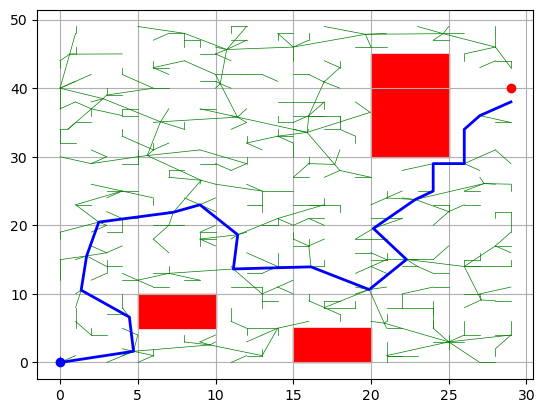

[<__main__.Node object at 0x7feb31511150>, <__main__.Node object at 0x7feb31510d90>, <__main__.Node object at 0x7feb2d5abca0>, <__main__.Node object at 0x7feb315134f0>, <__main__.Node object at 0x7feb2d5abdc0>, <__main__.Node object at 0x7feb2d5abee0>, <__main__.Node object at 0x7feb2d5abe20>, <__main__.Node object at 0x7feb2d5abfa0>, <__main__.Node object at 0x7feb2f26c4f0>, <__main__.Node object at 0x7feb2d5f84f0>, <__main__.Node object at 0x7feb2d5f93f0>, <__main__.Node object at 0x7feb2d5f9600>, <__main__.Node object at 0x7feb2d5f9ba0>, <__main__.Node object at 0x7feb2d5fb190>, <__main__.Node object at 0x7feb2d5fbbe0>, <__main__.Node object at 0x7feb2d626290>, <__main__.Node object at 0x7feb2d626cb0>]


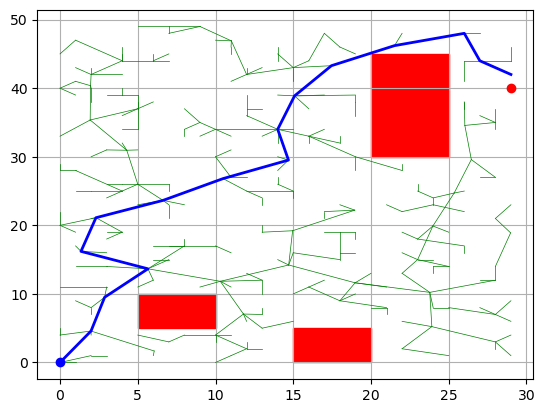

[<__main__.Node object at 0x7feb2eefb550>, <__main__.Node object at 0x7feb2eefb4c0>, <__main__.Node object at 0x7feb2efec250>, <__main__.Node object at 0x7feb2eeb23e0>, <__main__.Node object at 0x7feb2efef8b0>, <__main__.Node object at 0x7feb2d15b6d0>, <__main__.Node object at 0x7feb2d15baf0>, <__main__.Node object at 0x7feb2d2deb30>, <__main__.Node object at 0x7feb2d2dec50>, <__main__.Node object at 0x7feb2d190430>, <__main__.Node object at 0x7feb2d1908e0>, <__main__.Node object at 0x7feb2d190c40>, <__main__.Node object at 0x7feb2d190d60>, <__main__.Node object at 0x7feb2d191060>]


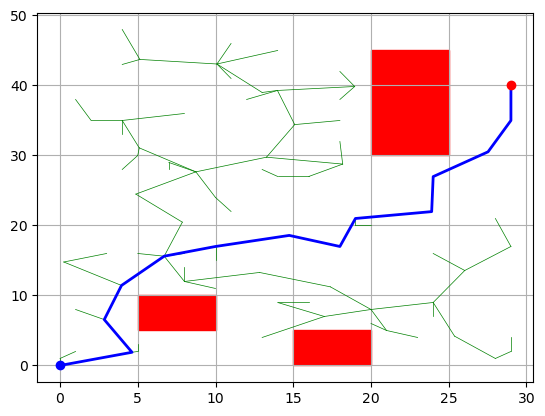

[<__main__.Node object at 0x7feb2d08c880>, <__main__.Node object at 0x7feb2d08d240>, <__main__.Node object at 0x7feb2d08d1b0>, <__main__.Node object at 0x7feb2d08d0f0>, <__main__.Node object at 0x7feb2d08d150>, <__main__.Node object at 0x7feb2d08cdf0>, <__main__.Node object at 0x7feb2d08cee0>, <__main__.Node object at 0x7feb2d08cbb0>, <__main__.Node object at 0x7feb2d08cd90>, <__main__.Node object at 0x7feb2d324f40>, <__main__.Node object at 0x7feb2d325420>, <__main__.Node object at 0x7feb2d325c30>, <__main__.Node object at 0x7feb2d325cf0>, <__main__.Node object at 0x7feb2d3261d0>, <__main__.Node object at 0x7feb2d324970>]


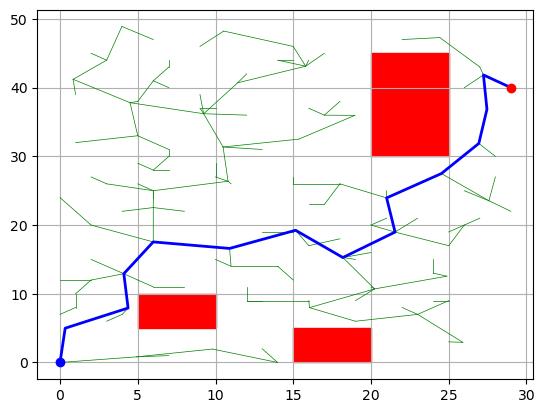

[<__main__.Node object at 0x7feb2efaf340>, <__main__.Node object at 0x7feb2efaece0>, <__main__.Node object at 0x7feb2efaef50>, <__main__.Node object at 0x7feb2d190b20>, <__main__.Node object at 0x7feb2efafbb0>, <__main__.Node object at 0x7feb2d1909d0>, <__main__.Node object at 0x7feb2d324400>, <__main__.Node object at 0x7feb2ef7e950>, <__main__.Node object at 0x7feb2ef7e4d0>, <__main__.Node object at 0x7feb2eeb0850>, <__main__.Node object at 0x7feb2eeb0cd0>, <__main__.Node object at 0x7feb3155b160>, <__main__.Node object at 0x7feb3155bd00>, <__main__.Node object at 0x7feb314d7a90>]


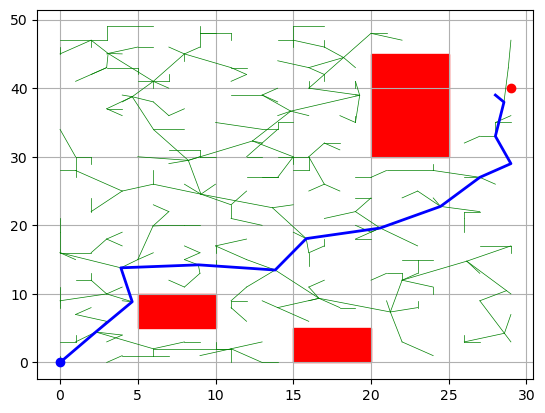

[<__main__.Node object at 0x7feb2f166e30>, <__main__.Node object at 0x7feb2f18ffa0>, <__main__.Node object at 0x7feb2d325ba0>, <__main__.Node object at 0x7feb2d325a50>, <__main__.Node object at 0x7feb2d325840>, <__main__.Node object at 0x7feb2d08dea0>, <__main__.Node object at 0x7feb2f2317b0>, <__main__.Node object at 0x7feb2d2bdf90>, <__main__.Node object at 0x7feb2d2be680>, <__main__.Node object at 0x7feb2d2bf0a0>, <__main__.Node object at 0x7feb2d2bf190>, <__main__.Node object at 0x7feb2d2bf610>, <__main__.Node object at 0x7feb2d2bf5b0>, <__main__.Node object at 0x7feb2d2bf880>, <__main__.Node object at 0x7feb2d2bf970>, <__main__.Node object at 0x7feb2d2c1a80>, <__main__.Node object at 0x7feb2d271c60>]


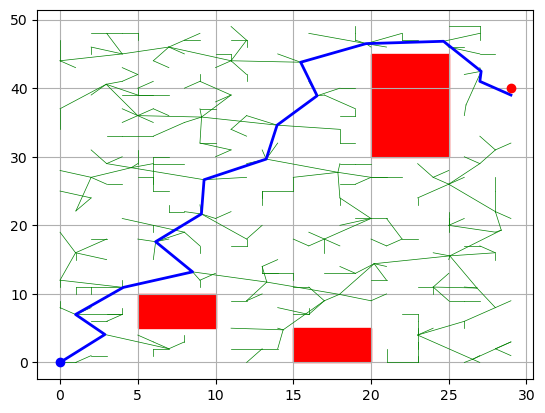

[<__main__.Node object at 0x7feb2eeb19f0>, <__main__.Node object at 0x7feb2f0264a0>, <__main__.Node object at 0x7feb2d4d3d30>, <__main__.Node object at 0x7feb2d4d3e80>, <__main__.Node object at 0x7feb2d4d3fd0>, <__main__.Node object at 0x7feb2d4d3eb0>, <__main__.Node object at 0x7feb2d4d3e20>, <__main__.Node object at 0x7feb2d4d3e50>, <__main__.Node object at 0x7feb2d501b10>, <__main__.Node object at 0x7feb2d500460>, <__main__.Node object at 0x7feb2d08e1d0>, <__main__.Node object at 0x7feb2d15bee0>, <__main__.Node object at 0x7feb2d5f63b0>, <__main__.Node object at 0x7feb2d5f6a70>, <__main__.Node object at 0x7feb2d5f75e0>, <__main__.Node object at 0x7feb2d5f7be0>, <__main__.Node object at 0x7feb2d486b00>, <__main__.Node object at 0x7feb2d58cd90>, <__main__.Node object at 0x7feb2d58e080>, <__main__.Node object at 0x7feb2d58e6e0>, <__main__.Node object at 0x7feb2d58ece0>, <__main__.Node object at 0x7feb2d58f6d0>]


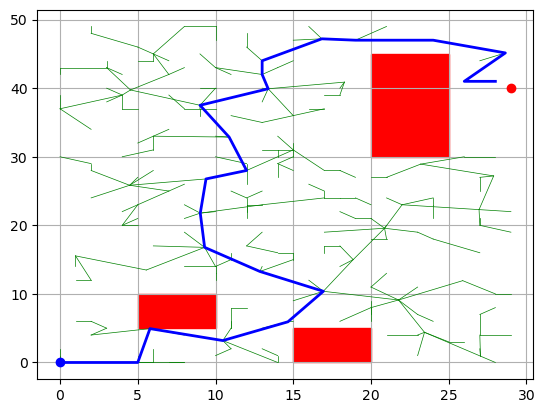

[<__main__.Node object at 0x7feb2d4d1e70>, <__main__.Node object at 0x7feb2d2be860>, <__main__.Node object at 0x7feb2f232230>, <__main__.Node object at 0x7feb2f231f90>, <__main__.Node object at 0x7feb2f231ff0>, <__main__.Node object at 0x7feb2f2320e0>, <__main__.Node object at 0x7feb2f232440>, <__main__.Node object at 0x7feb2f233010>, <__main__.Node object at 0x7feb314d7eb0>, <__main__.Node object at 0x7feb314d6950>, <__main__.Node object at 0x7feb314d6590>, <__main__.Node object at 0x7feb314d7a60>, <__main__.Node object at 0x7feb314d6740>, <__main__.Node object at 0x7feb2f207b50>, <__main__.Node object at 0x7feb2f204d00>, <__main__.Node object at 0x7feb2f204a30>, <__main__.Node object at 0x7feb2f205870>, <__main__.Node object at 0x7feb2ef4be50>]


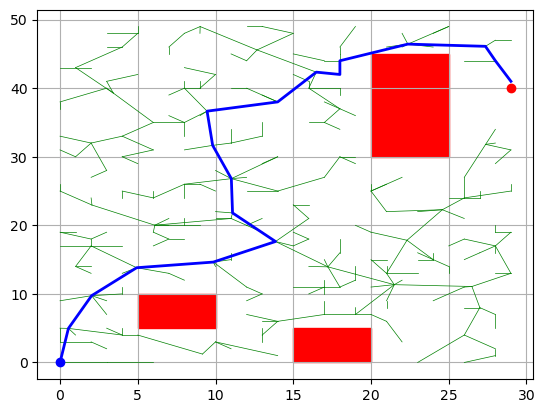

[<__main__.Node object at 0x7feb2d08f3d0>, <__main__.Node object at 0x7feb2d08f610>, <__main__.Node object at 0x7feb2d08fca0>, <__main__.Node object at 0x7feb2d08fb80>, <__main__.Node object at 0x7feb2d08d300>, <__main__.Node object at 0x7feb2d08ffa0>, <__main__.Node object at 0x7feb2d08f5e0>, <__main__.Node object at 0x7feb2d08f5b0>, <__main__.Node object at 0x7feb2d08fb20>, <__main__.Node object at 0x7feb2d5f7730>, <__main__.Node object at 0x7feb2f232710>, <__main__.Node object at 0x7feb2d5aada0>, <__main__.Node object at 0x7feb2efef100>, <__main__.Node object at 0x7feb2f26d4b0>, <__main__.Node object at 0x7feb2f26c5e0>, <__main__.Node object at 0x7feb2f26dab0>, <__main__.Node object at 0x7feb2f26df90>, <__main__.Node object at 0x7feb2d2c10f0>]


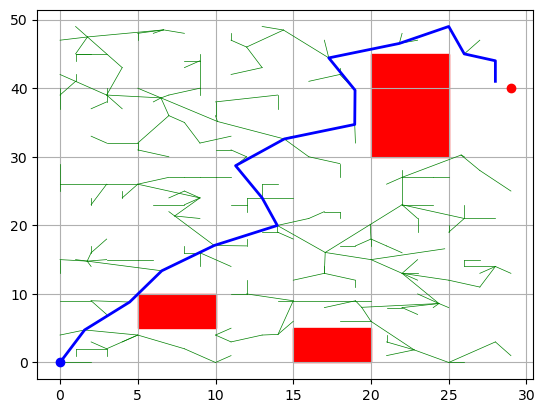

[<__main__.Node object at 0x7feb2d1a3eb0>, <__main__.Node object at 0x7feb2d1a3f10>, <__main__.Node object at 0x7feb2d1a1d50>, <__main__.Node object at 0x7feb2d1a1b40>, <__main__.Node object at 0x7feb2d1a1ba0>, <__main__.Node object at 0x7feb314d6e60>, <__main__.Node object at 0x7feb314d6b30>, <__main__.Node object at 0x7feb2d1f01c0>, <__main__.Node object at 0x7feb2d17bdf0>, <__main__.Node object at 0x7feb2d1c3190>, <__main__.Node object at 0x7feb2d0840a0>, <__main__.Node object at 0x7feb2d084100>, <__main__.Node object at 0x7feb2d0854e0>, <__main__.Node object at 0x7feb2d085de0>]


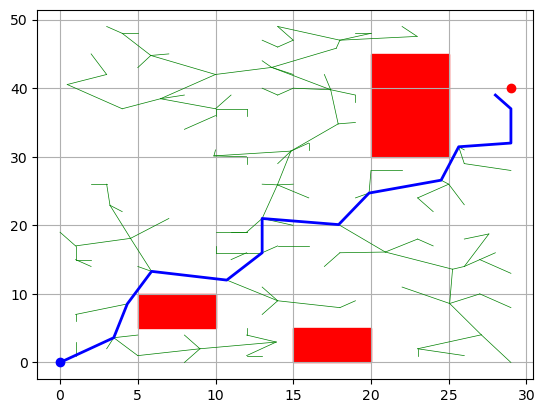

[<__main__.Node object at 0x7feb2f26fbb0>, <__main__.Node object at 0x7feb2d17a2f0>, <__main__.Node object at 0x7feb2d17a2c0>, <__main__.Node object at 0x7feb2d1f1150>, <__main__.Node object at 0x7feb2d17a1d0>, <__main__.Node object at 0x7feb2d1f1060>, <__main__.Node object at 0x7feb2d1f0040>, <__main__.Node object at 0x7feb2d1f1870>, <__main__.Node object at 0x7feb2d1f1a80>, <__main__.Node object at 0x7feb2d1f1ae0>, <__main__.Node object at 0x7feb2d1f1f90>, <__main__.Node object at 0x7feb2d1a1de0>, <__main__.Node object at 0x7feb2d1c28c0>, <__main__.Node object at 0x7feb2d1c03a0>]


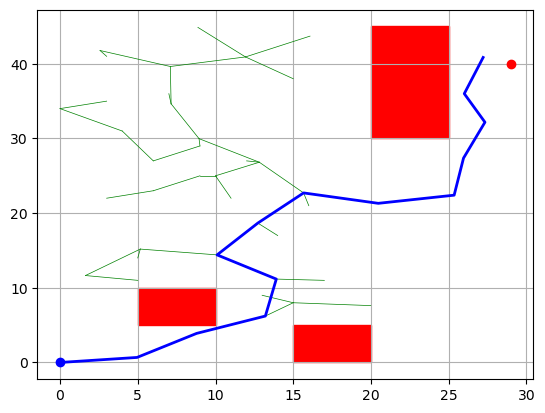

[<__main__.Node object at 0x7feb2d1c2ec0>, <__main__.Node object at 0x7feb2d1c2f20>, <__main__.Node object at 0x7feb2d1c2d10>, <__main__.Node object at 0x7feb2d1595a0>, <__main__.Node object at 0x7feb2d1593f0>, <__main__.Node object at 0x7feb2d15b880>, <__main__.Node object at 0x7feb2d1592a0>, <__main__.Node object at 0x7feb2d159630>, <__main__.Node object at 0x7feb2d159ab0>, <__main__.Node object at 0x7feb2d159180>, <__main__.Node object at 0x7feb2f23d000>, <__main__.Node object at 0x7feb2f23e560>, <__main__.Node object at 0x7feb2f23cd00>, <__main__.Node object at 0x7feb2d17b790>, <__main__.Node object at 0x7feb2ef7c970>, <__main__.Node object at 0x7feb2f23d5d0>, <__main__.Node object at 0x7feb2ef7c8b0>]


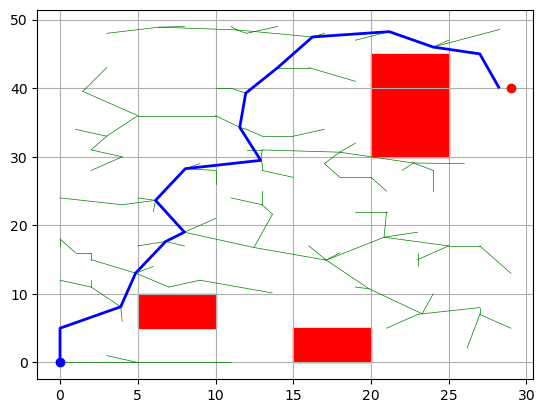

[<__main__.Node object at 0x7feb2d08f4f0>, <__main__.Node object at 0x7feb2d2de830>, <__main__.Node object at 0x7feb2d2df970>, <__main__.Node object at 0x7feb2d2deb90>, <__main__.Node object at 0x7feb2d2de8f0>, <__main__.Node object at 0x7feb4bb7b010>, <__main__.Node object at 0x7feb2d5aa2c0>, <__main__.Node object at 0x7feb2d5abb80>, <__main__.Node object at 0x7feb2d5aa560>, <__main__.Node object at 0x7feb2d1a0310>, <__main__.Node object at 0x7feb2ef49de0>, <__main__.Node object at 0x7feb2ef48430>, <__main__.Node object at 0x7feb2efec1f0>, <__main__.Node object at 0x7feb2d5f6590>, <__main__.Node object at 0x7feb2d5f4610>]


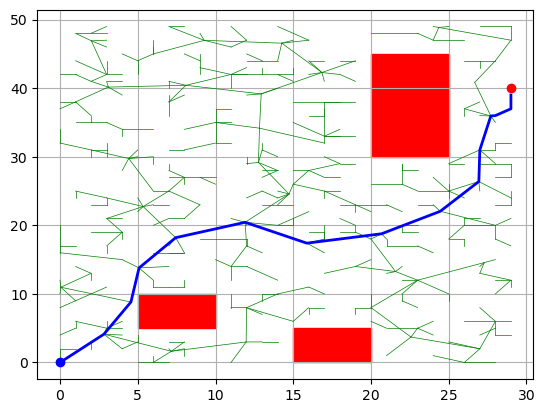

[<__main__.Node object at 0x7feb2d158130>, <__main__.Node object at 0x7feb2d159ea0>, <__main__.Node object at 0x7feb2f23d360>, <__main__.Node object at 0x7feb2d55e140>, <__main__.Node object at 0x7feb2d55e260>, <__main__.Node object at 0x7feb2d55e320>, <__main__.Node object at 0x7feb2d55e4a0>, <__main__.Node object at 0x7feb2d55e410>, <__main__.Node object at 0x7feb2d55e3b0>, <__main__.Node object at 0x7feb2d55ee00>, <__main__.Node object at 0x7feb2d55ee30>, <__main__.Node object at 0x7feb2d55f400>, <__main__.Node object at 0x7feb2f3c70d0>, <__main__.Node object at 0x7feb2d568880>, <__main__.Node object at 0x7feb2d568e20>]


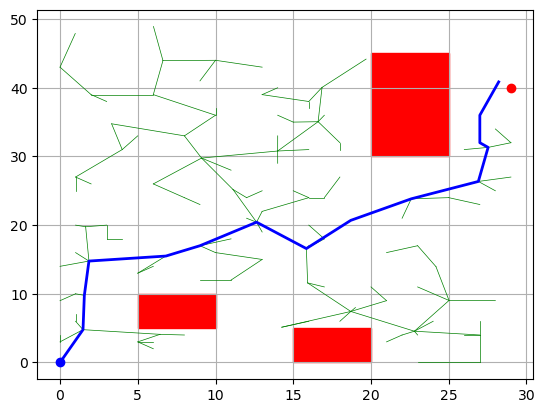

[<__main__.Node object at 0x7feb2f3ebbe0>, <__main__.Node object at 0x7feb2d57f910>, <__main__.Node object at 0x7feb2d57fc70>, <__main__.Node object at 0x7feb2d57f040>, <__main__.Node object at 0x7feb2d57c6d0>, <__main__.Node object at 0x7feb2d57cbe0>, <__main__.Node object at 0x7feb2d57d240>, <__main__.Node object at 0x7feb2d57cee0>, <__main__.Node object at 0x7feb2d57f460>, <__main__.Node object at 0x7feb2d57d930>, <__main__.Node object at 0x7feb2f080a30>, <__main__.Node object at 0x7feb2f0806d0>, <__main__.Node object at 0x7feb2f082410>, <__main__.Node object at 0x7feb2f083250>]


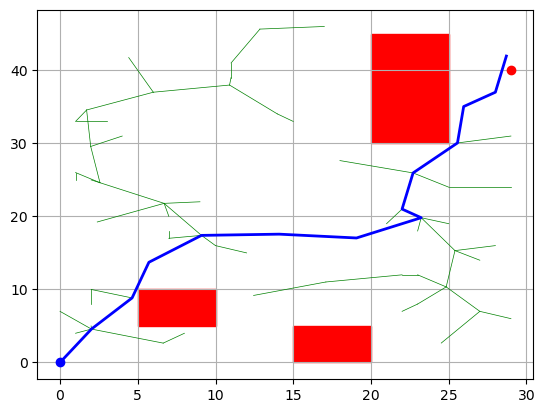

[<__main__.Node object at 0x7feb2d5689d0>, <__main__.Node object at 0x7feb2d568a00>, <__main__.Node object at 0x7feb2d4d32e0>, <__main__.Node object at 0x7feb2d5688b0>, <__main__.Node object at 0x7feb2d4d1db0>, <__main__.Node object at 0x7feb2d4d2aa0>, <__main__.Node object at 0x7feb2d4d2b90>, <__main__.Node object at 0x7feb2d4d1f90>, <__main__.Node object at 0x7feb2d4d3700>, <__main__.Node object at 0x7feb2d4d19c0>, <__main__.Node object at 0x7feb2d4d3730>, <__main__.Node object at 0x7feb2d4d3820>, <__main__.Node object at 0x7feb2d4d3a90>, <__main__.Node object at 0x7feb2d3256c0>, <__main__.Node object at 0x7feb2f18c340>, <__main__.Node object at 0x7feb2f18f820>, <__main__.Node object at 0x7feb2f2070a0>, <__main__.Node object at 0x7feb2f206d10>, <__main__.Node object at 0x7feb2f2060b0>]


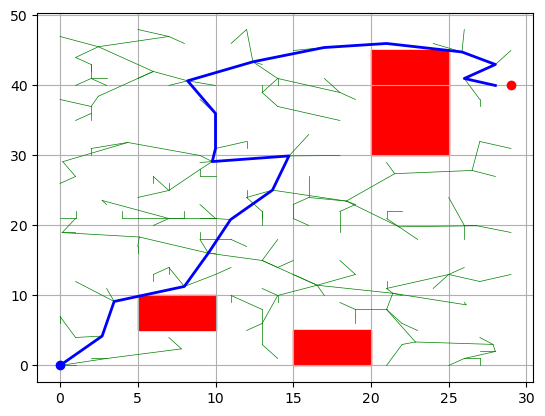

[<__main__.Node object at 0x7feb2ef7f070>, <__main__.Node object at 0x7feb2f1d7eb0>, <__main__.Node object at 0x7feb2f1d7a90>, <__main__.Node object at 0x7feb2f1d6bf0>, <__main__.Node object at 0x7feb2d191690>, <__main__.Node object at 0x7feb2d190580>, <__main__.Node object at 0x7feb2d190040>, <__main__.Node object at 0x7feb2d193bb0>, <__main__.Node object at 0x7feb2d1929b0>, <__main__.Node object at 0x7feb2d190b50>, <__main__.Node object at 0x7feb2f0814b0>, <__main__.Node object at 0x7feb2d15a260>, <__main__.Node object at 0x7feb2d158430>, <__main__.Node object at 0x7feb2d15b100>, <__main__.Node object at 0x7feb2d15bf70>]


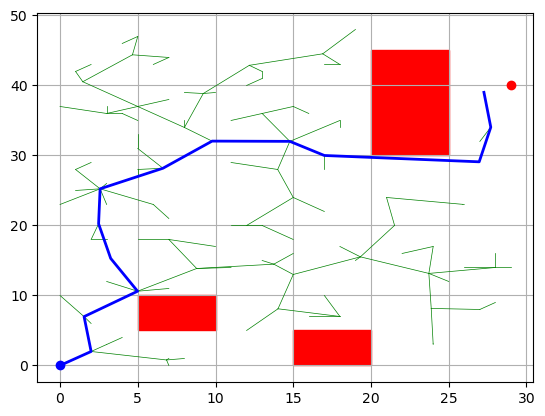

[<__main__.Node object at 0x7feb2eeb0f40>, <__main__.Node object at 0x7feb2eeb1240>, <__main__.Node object at 0x7feb2eeb1e10>, <__main__.Node object at 0x7feb2d1a2ad0>, <__main__.Node object at 0x7feb2d1a2a40>, <__main__.Node object at 0x7feb2d1a3a60>, <__main__.Node object at 0x7feb2d1a1d80>, <__main__.Node object at 0x7feb2d1a2980>, <__main__.Node object at 0x7feb2d1a2a10>, <__main__.Node object at 0x7feb2d1a2a70>, <__main__.Node object at 0x7feb2d1a2bf0>, <__main__.Node object at 0x7feb2d1a1660>, <__main__.Node object at 0x7feb2d2beb00>, <__main__.Node object at 0x7feb2d487760>, <__main__.Node object at 0x7feb2d4856c0>, <__main__.Node object at 0x7feb2d085d80>, <__main__.Node object at 0x7feb2d0872b0>, <__main__.Node object at 0x7feb2ef4a140>]


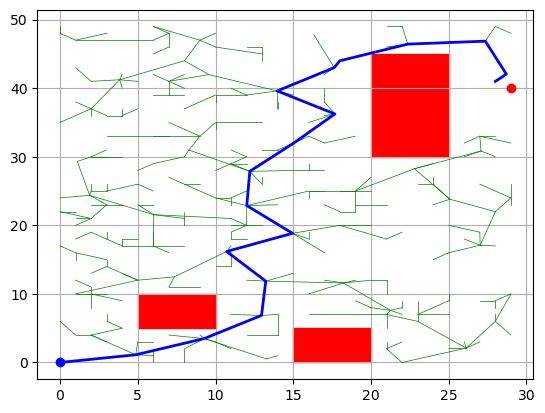

[<__main__.Node object at 0x7feb2d1d9750>, <__main__.Node object at 0x7feb2d1d9210>, <__main__.Node object at 0x7feb2d1d9780>, <__main__.Node object at 0x7feb2d1d9870>, <__main__.Node object at 0x7feb2d1d95a0>, <__main__.Node object at 0x7feb2d1d9690>, <__main__.Node object at 0x7feb2d1d96f0>, <__main__.Node object at 0x7feb2d1d9720>, <__main__.Node object at 0x7feb2d2c00d0>, <__main__.Node object at 0x7feb2d2c0ca0>, <__main__.Node object at 0x7feb2d2c0b20>, <__main__.Node object at 0x7feb2d2c0c70>, <__main__.Node object at 0x7feb2d272230>, <__main__.Node object at 0x7feb2d1a1f30>, <__main__.Node object at 0x7feb2d1a3160>, <__main__.Node object at 0x7feb2d1a3e80>, <__main__.Node object at 0x7feb2d1a01c0>]


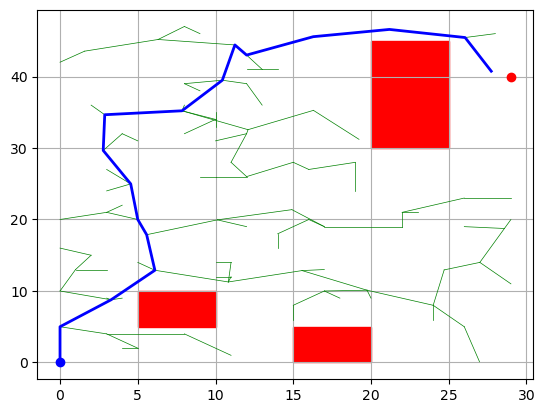

[<__main__.Node object at 0x7feb2d1a19f0>, <__main__.Node object at 0x7feb2d084b80>, <__main__.Node object at 0x7feb2d084bb0>, <__main__.Node object at 0x7feb2f165fc0>, <__main__.Node object at 0x7feb2f166860>, <__main__.Node object at 0x7feb2f166770>, <__main__.Node object at 0x7feb2f167910>, <__main__.Node object at 0x7feb2f166260>, <__main__.Node object at 0x7feb2f167970>, <__main__.Node object at 0x7feb2f165c60>, <__main__.Node object at 0x7feb2f165f60>, <__main__.Node object at 0x7feb2f167f10>, <__main__.Node object at 0x7feb2f026ce0>, <__main__.Node object at 0x7feb2f0242b0>]


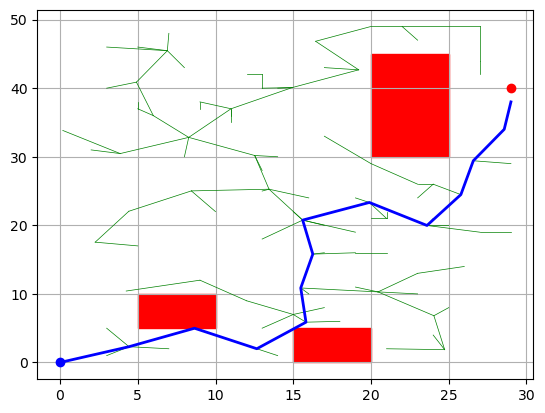

[<__main__.Node object at 0x7feb2d2716c0>, <__main__.Node object at 0x7feb315019f0>, <__main__.Node object at 0x7feb31502620>, <__main__.Node object at 0x7feb315022c0>, <__main__.Node object at 0x7feb31500760>, <__main__.Node object at 0x7feb315033a0>, <__main__.Node object at 0x7feb315018a0>, <__main__.Node object at 0x7feb31503cd0>, <__main__.Node object at 0x7feb31500a30>, <__main__.Node object at 0x7feb31502aa0>, <__main__.Node object at 0x7feb2d1d9c00>, <__main__.Node object at 0x7feb2f3329b0>, <__main__.Node object at 0x7feb2f333d00>, <__main__.Node object at 0x7feb2f330a00>, <__main__.Node object at 0x7feb2f333e50>, <__main__.Node object at 0x7feb2d327ac0>, <__main__.Node object at 0x7feb2d325390>, <__main__.Node object at 0x7feb2f129570>]


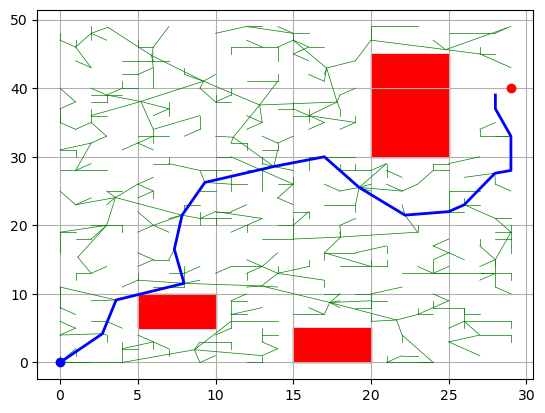

[<__main__.Node object at 0x7feb2ce57f40>, <__main__.Node object at 0x7feb2ce8e2c0>, <__main__.Node object at 0x7feb2ce8e740>, <__main__.Node object at 0x7feb2ce8e710>, <__main__.Node object at 0x7feb2ce8e830>, <__main__.Node object at 0x7feb2ce8e590>, <__main__.Node object at 0x7feb2ce8e4d0>, <__main__.Node object at 0x7feb2f1d6d40>, <__main__.Node object at 0x7feb2f1d4d60>, <__main__.Node object at 0x7feb2f1d45e0>, <__main__.Node object at 0x7feb2f1d66e0>, <__main__.Node object at 0x7feb2f1d6080>, <__main__.Node object at 0x7feb2f1d75b0>]


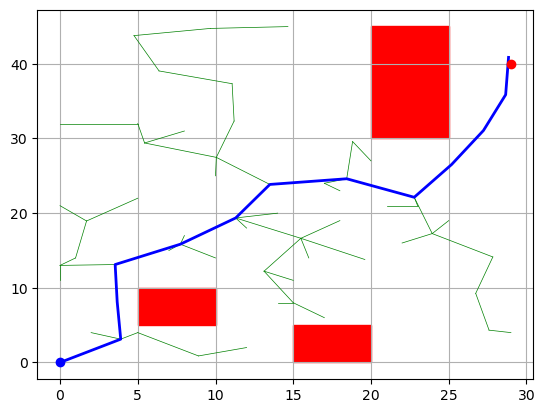

[<__main__.Node object at 0x7feb2f18f280>, <__main__.Node object at 0x7feb2f18f340>, <__main__.Node object at 0x7feb2f18c730>, <__main__.Node object at 0x7feb2f18d3f0>, <__main__.Node object at 0x7feb2f158220>, <__main__.Node object at 0x7feb2f15a590>, <__main__.Node object at 0x7feb2f1593f0>, <__main__.Node object at 0x7feb2f158070>, <__main__.Node object at 0x7feb2f159570>, <__main__.Node object at 0x7feb2f333a60>, <__main__.Node object at 0x7feb2f331540>, <__main__.Node object at 0x7feb2d627760>, <__main__.Node object at 0x7feb2d627b80>, <__main__.Node object at 0x7feb2d625f30>, <__main__.Node object at 0x7feb2d624dc0>, <__main__.Node object at 0x7feb2d625150>, <__main__.Node object at 0x7feb2d627400>, <__main__.Node object at 0x7feb2f027550>]


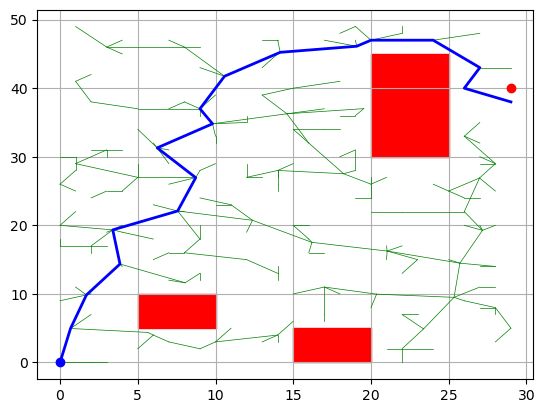

[<__main__.Node object at 0x7feb2cec42e0>, <__main__.Node object at 0x7feb2d08c970>, <__main__.Node object at 0x7feb2d08c2e0>, <__main__.Node object at 0x7feb2efef820>, <__main__.Node object at 0x7feb2d08c490>, <__main__.Node object at 0x7feb2efeefe0>, <__main__.Node object at 0x7feb2efef730>, <__main__.Node object at 0x7feb2efeefb0>, <__main__.Node object at 0x7feb2ceb1540>, <__main__.Node object at 0x7feb2f15a290>, <__main__.Node object at 0x7feb2d5fbd00>, <__main__.Node object at 0x7feb2d5f83a0>, <__main__.Node object at 0x7feb2d5fba60>, <__main__.Node object at 0x7feb2d5f91b0>, <__main__.Node object at 0x7feb2f26c0a0>]


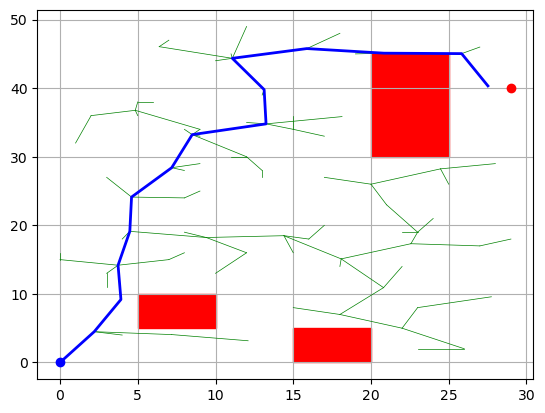

[<__main__.Node object at 0x7feb2d58ec20>, <__main__.Node object at 0x7feb2d58f1c0>, <__main__.Node object at 0x7feb2d58ed40>, <__main__.Node object at 0x7feb2d58eaa0>, <__main__.Node object at 0x7feb2d58f190>, <__main__.Node object at 0x7feb2d58ee90>, <__main__.Node object at 0x7feb2d58d270>, <__main__.Node object at 0x7feb2d58d0f0>, <__main__.Node object at 0x7feb2d58c730>, <__main__.Node object at 0x7feb2d2c2a10>, <__main__.Node object at 0x7feb2d2c1240>, <__main__.Node object at 0x7feb2d2c1c30>, <__main__.Node object at 0x7feb2d6255a0>, <__main__.Node object at 0x7feb2d2725c0>, <__main__.Node object at 0x7feb2d273520>, <__main__.Node object at 0x7feb2d2733a0>, <__main__.Node object at 0x7feb2d273250>, <__main__.Node object at 0x7feb2d270af0>, <__main__.Node object at 0x7feb2d178070>]


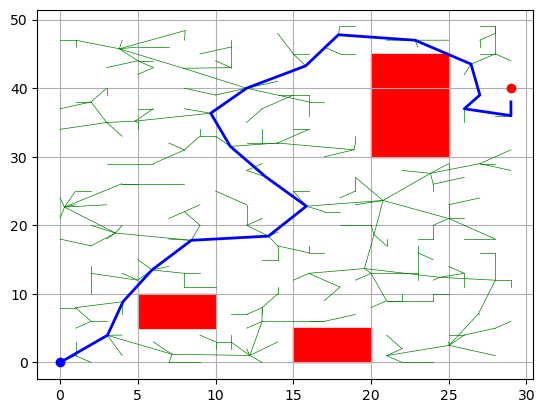

[<__main__.Node object at 0x7feb2ccbbf40>, <__main__.Node object at 0x7feb2d58d720>, <__main__.Node object at 0x7feb2d58cc10>, <__main__.Node object at 0x7feb2d58cb20>, <__main__.Node object at 0x7feb2d58c970>, <__main__.Node object at 0x7feb2d58d4b0>, <__main__.Node object at 0x7feb2d58dd20>, <__main__.Node object at 0x7feb2d58d510>, <__main__.Node object at 0x7feb2d58e4d0>, <__main__.Node object at 0x7feb2d58f160>, <__main__.Node object at 0x7feb2cce48e0>, <__main__.Node object at 0x7feb2cce7d30>, <__main__.Node object at 0x7feb2f233460>, <__main__.Node object at 0x7feb2f233550>, <__main__.Node object at 0x7feb2d2c06a0>, <__main__.Node object at 0x7feb3155a3e0>, <__main__.Node object at 0x7feb3155b6a0>]


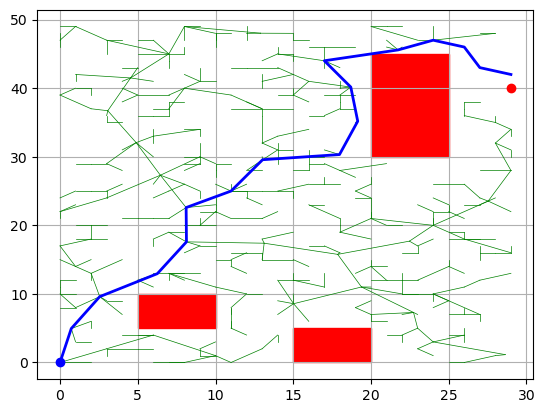

[<__main__.Node object at 0x7feb3155bfd0>, <__main__.Node object at 0x7feb3155b1c0>, <__main__.Node object at 0x7feb2d2dd450>, <__main__.Node object at 0x7feb31558be0>, <__main__.Node object at 0x7feb2d2dd8d0>, <__main__.Node object at 0x7feb2d2dd2a0>, <__main__.Node object at 0x7feb2d2dc730>, <__main__.Node object at 0x7feb2d2ddff0>, <__main__.Node object at 0x7feb2d625ea0>, <__main__.Node object at 0x7feb2d5a85e0>, <__main__.Node object at 0x7feb2d5a9060>, <__main__.Node object at 0x7feb2f23c8b0>, <__main__.Node object at 0x7feb2cf24280>, <__main__.Node object at 0x7feb2cf242e0>, <__main__.Node object at 0x7feb2cf24820>, <__main__.Node object at 0x7feb2cf25c30>, <__main__.Node object at 0x7feb2cf26560>]


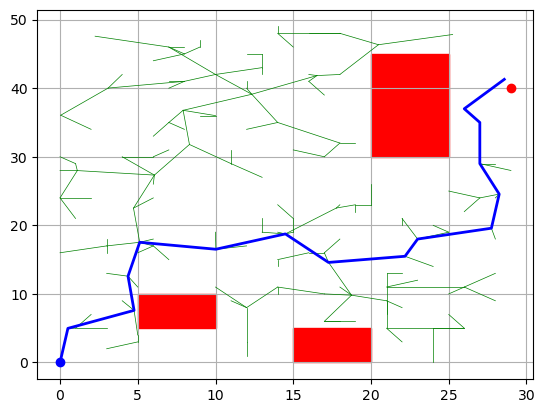

[<__main__.Node object at 0x7feb2d4d0430>, <__main__.Node object at 0x7feb2d4d23b0>, <__main__.Node object at 0x7feb2d4d12a0>, <__main__.Node object at 0x7feb2f027340>, <__main__.Node object at 0x7feb2f026260>, <__main__.Node object at 0x7feb2f024e20>, <__main__.Node object at 0x7feb2f026d10>, <__main__.Node object at 0x7feb2f12a2c0>, <__main__.Node object at 0x7feb2f12a6b0>, <__main__.Node object at 0x7feb2f12bd00>, <__main__.Node object at 0x7feb2f23ee30>, <__main__.Node object at 0x7feb2ce8f3a0>, <__main__.Node object at 0x7feb2ce8f490>, <__main__.Node object at 0x7feb2ce8f4f0>, <__main__.Node object at 0x7feb2ce8f160>, <__main__.Node object at 0x7feb2d2701f0>, <__main__.Node object at 0x7feb2d270400>, <__main__.Node object at 0x7feb2d2bded0>, <__main__.Node object at 0x7feb2d2bc8b0>]


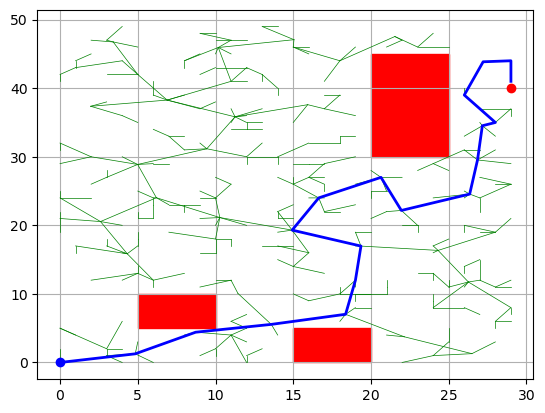

[<__main__.Node object at 0x7feb2ef7e380>, <__main__.Node object at 0x7feb2ef7df90>, <__main__.Node object at 0x7feb2ef7e260>, <__main__.Node object at 0x7feb2ef7c5e0>, <__main__.Node object at 0x7feb2d273c10>, <__main__.Node object at 0x7feb2d4d1e10>, <__main__.Node object at 0x7feb2d56b2e0>, <__main__.Node object at 0x7feb2d56ad40>, <__main__.Node object at 0x7feb2d56b2b0>, <__main__.Node object at 0x7feb2d569990>, <__main__.Node object at 0x7feb2d569210>, <__main__.Node object at 0x7feb2d569d20>, <__main__.Node object at 0x7feb2d56add0>, <__main__.Node object at 0x7feb2d56b940>, <__main__.Node object at 0x7feb2f18d6f0>, <__main__.Node object at 0x7feb2f3e9c30>]


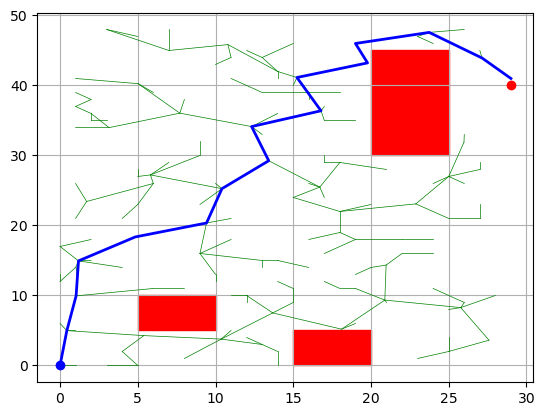

[<__main__.Node object at 0x7feb2d6242b0>, <__main__.Node object at 0x7feb2d626e30>, <__main__.Node object at 0x7feb2d6261d0>, <__main__.Node object at 0x7feb2d6275b0>, <__main__.Node object at 0x7feb2d624520>, <__main__.Node object at 0x7feb2d624df0>, <__main__.Node object at 0x7feb2d626c20>, <__main__.Node object at 0x7feb2d627220>, <__main__.Node object at 0x7feb2d626830>, <__main__.Node object at 0x7feb2d624b20>, <__main__.Node object at 0x7feb2d6278e0>, <__main__.Node object at 0x7feb2f024730>, <__main__.Node object at 0x7feb2d1c3760>, <__main__.Node object at 0x7feb2f23d840>, <__main__.Node object at 0x7feb2f23f0a0>, <__main__.Node object at 0x7feb2f23d030>, <__main__.Node object at 0x7feb3155b430>]


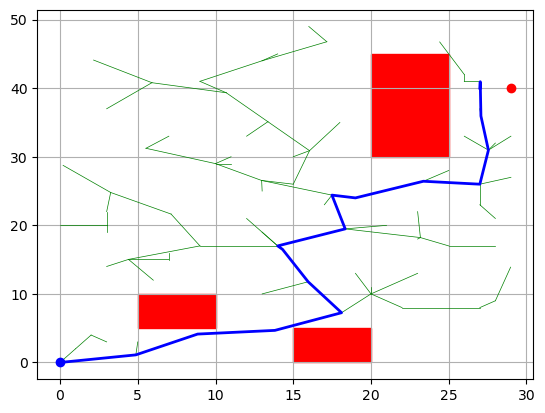

[<__main__.Node object at 0x7feb2d56a890>, <__main__.Node object at 0x7feb2d56a950>, <__main__.Node object at 0x7feb2d56a0e0>, <__main__.Node object at 0x7feb2d57e6e0>, <__main__.Node object at 0x7feb2d57d3f0>, <__main__.Node object at 0x7feb2d57ca90>, <__main__.Node object at 0x7feb2d57cd90>, <__main__.Node object at 0x7feb2d57c820>, <__main__.Node object at 0x7feb2d57f7f0>, <__main__.Node object at 0x7feb2d57d0f0>, <__main__.Node object at 0x7feb2d1c0a00>, <__main__.Node object at 0x7feb2d325750>, <__main__.Node object at 0x7feb2d324820>, <__main__.Node object at 0x7feb2d3271f0>, <__main__.Node object at 0x7feb2f0804c0>, <__main__.Node object at 0x7feb2f083c40>, <__main__.Node object at 0x7feb2f0807f0>, <__main__.Node object at 0x7feb2d1916f0>, <__main__.Node object at 0x7feb2d1900a0>, <__main__.Node object at 0x7feb2d193160>]


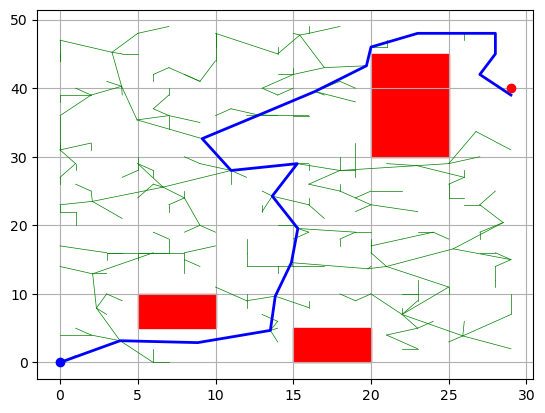

[<__main__.Node object at 0x7feb2d5256f0>, <__main__.Node object at 0x7feb2d2c1450>, <__main__.Node object at 0x7feb2d2c19f0>, <__main__.Node object at 0x7feb2d2c3610>, <__main__.Node object at 0x7feb2d2c33d0>, <__main__.Node object at 0x7feb2d2c0940>, <__main__.Node object at 0x7feb2d2c0fd0>, <__main__.Node object at 0x7feb2d2c0be0>, <__main__.Node object at 0x7feb2d2c2560>, <__main__.Node object at 0x7feb2d2c3070>, <__main__.Node object at 0x7feb2d2c3430>, <__main__.Node object at 0x7feb2d2c13f0>, <__main__.Node object at 0x7feb2d2c0760>, <__main__.Node object at 0x7feb2cec5ff0>]


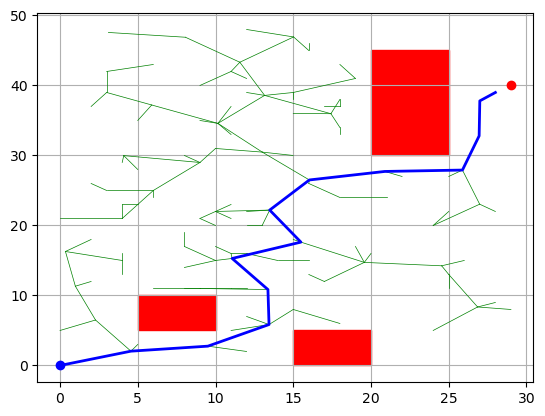

[<__main__.Node object at 0x7feb2d192fb0>, <__main__.Node object at 0x7feb2d193610>, <__main__.Node object at 0x7feb2d326530>, <__main__.Node object at 0x7feb2f3e9090>, <__main__.Node object at 0x7feb2f3e8bb0>, <__main__.Node object at 0x7feb2f3eb370>, <__main__.Node object at 0x7feb2f3e8a90>, <__main__.Node object at 0x7feb2f3e9810>, <__main__.Node object at 0x7feb2f3ebbb0>, <__main__.Node object at 0x7feb2d502d40>, <__main__.Node object at 0x7feb2d501840>, <__main__.Node object at 0x7feb2ef499c0>, <__main__.Node object at 0x7feb2ef4b370>, <__main__.Node object at 0x7feb2ef496f0>, <__main__.Node object at 0x7feb2d086ef0>]


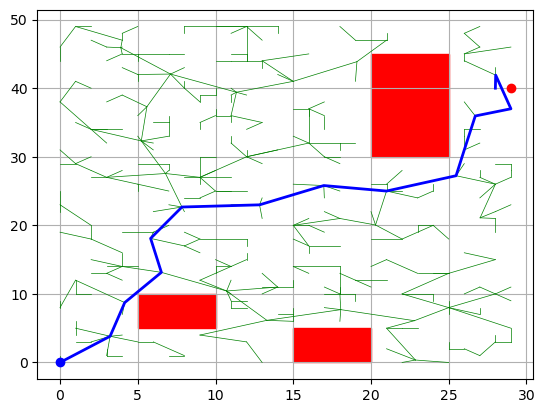

[<__main__.Node object at 0x7feb2d4877c0>, <__main__.Node object at 0x7feb2d487850>, <__main__.Node object at 0x7feb2d486c80>, <__main__.Node object at 0x7feb2d485cc0>, <__main__.Node object at 0x7feb2f207fd0>, <__main__.Node object at 0x7feb2f204040>, <__main__.Node object at 0x7feb2f206dd0>, <__main__.Node object at 0x7feb2f204340>, <__main__.Node object at 0x7feb2f2048b0>, <__main__.Node object at 0x7feb2f207bb0>, <__main__.Node object at 0x7feb2f205150>, <__main__.Node object at 0x7feb2d2c2e60>, <__main__.Node object at 0x7feb2f330700>, <__main__.Node object at 0x7feb2f332740>, <__main__.Node object at 0x7feb2d1c2680>, <__main__.Node object at 0x7feb2d1c2f50>, <__main__.Node object at 0x7feb2d1c06a0>, <__main__.Node object at 0x7feb2d1c2b90>, <__main__.Node object at 0x7feb2d1c0c10>, <__main__.Node object at 0x7feb2d1c2170>, <__main__.Node object at 0x7feb2d1c31c0>, <__main__.Node object at 0x7feb2d56a9e0>]


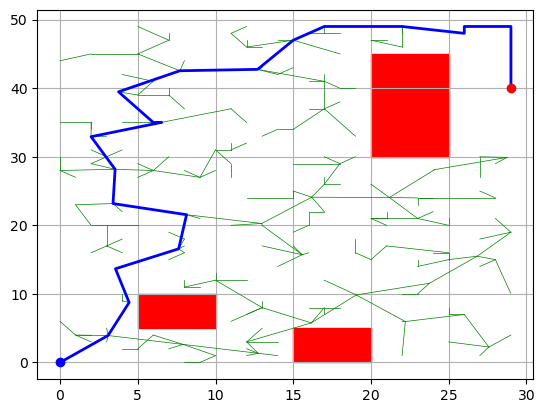

[<__main__.Node object at 0x7feb2d399ea0>, <__main__.Node object at 0x7feb2d399f00>, <__main__.Node object at 0x7feb2d399de0>, <__main__.Node object at 0x7feb2d399c90>, <__main__.Node object at 0x7feb2d4382b0>, <__main__.Node object at 0x7feb2d438160>, <__main__.Node object at 0x7feb2d4381c0>, <__main__.Node object at 0x7feb2d503850>, <__main__.Node object at 0x7feb2ceab1c0>, <__main__.Node object at 0x7feb2ceab5b0>, <__main__.Node object at 0x7feb2ceab940>, <__main__.Node object at 0x7feb2ceabe80>, <__main__.Node object at 0x7feb2ceca080>]


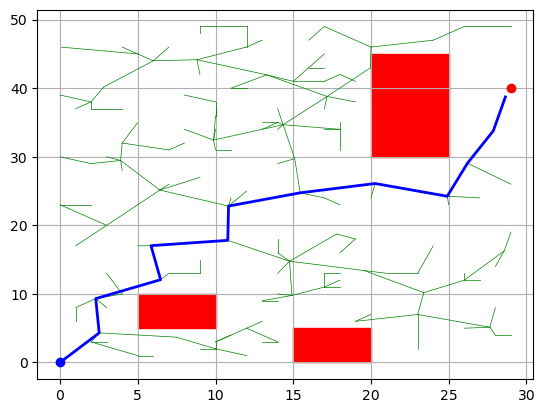

[<__main__.Node object at 0x7feb2d2bfe80>, <__main__.Node object at 0x7feb2f27e3e0>, <__main__.Node object at 0x7feb2f27fee0>, <__main__.Node object at 0x7feb2f27e4a0>, <__main__.Node object at 0x7feb2f27f610>, <__main__.Node object at 0x7feb2f27d570>, <__main__.Node object at 0x7feb2f27c100>, <__main__.Node object at 0x7feb2f27d3c0>, <__main__.Node object at 0x7feb2eeb2bc0>, <__main__.Node object at 0x7feb2d273e50>, <__main__.Node object at 0x7feb2d2718a0>, <__main__.Node object at 0x7feb2d270e50>, <__main__.Node object at 0x7feb2d270fa0>, <__main__.Node object at 0x7feb2d272ad0>]


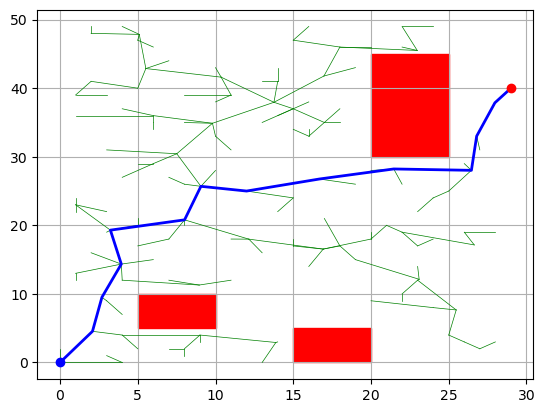

[<__main__.Node object at 0x7feb2ceab8b0>, <__main__.Node object at 0x7feb2ceab8e0>, <__main__.Node object at 0x7feb2d39a230>, <__main__.Node object at 0x7feb2f27f280>, <__main__.Node object at 0x7feb2d0876d0>, <__main__.Node object at 0x7feb2d085c00>, <__main__.Node object at 0x7feb2d4879a0>, <__main__.Node object at 0x7feb2d486830>, <__main__.Node object at 0x7feb2d484610>, <__main__.Node object at 0x7feb2d4855a0>, <__main__.Node object at 0x7feb2d4844c0>, <__main__.Node object at 0x7feb2d487250>, <__main__.Node object at 0x7feb2f332dd0>, <__main__.Node object at 0x7feb2f331780>, <__main__.Node object at 0x7feb2f159600>, <__main__.Node object at 0x7feb2f15b880>, <__main__.Node object at 0x7feb2f15bf40>, <__main__.Node object at 0x7feb2f15abc0>]


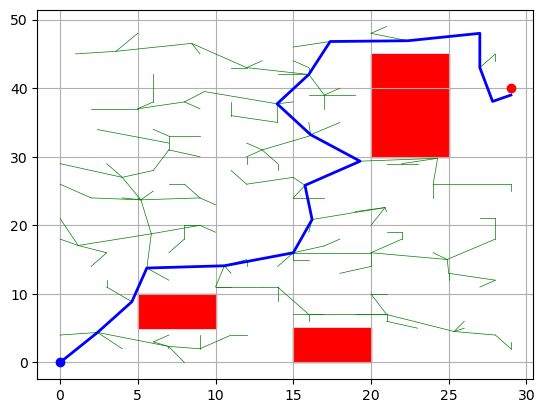

[<__main__.Node object at 0x7feb2ccb84f0>, <__main__.Node object at 0x7feb2cec57e0>, <__main__.Node object at 0x7feb2cec4340>, <__main__.Node object at 0x7feb2cec40d0>, <__main__.Node object at 0x7feb2cec4130>, <__main__.Node object at 0x7feb2cec5150>, <__main__.Node object at 0x7feb2d08d540>, <__main__.Node object at 0x7feb2d08ee90>, <__main__.Node object at 0x7feb2d08e200>, <__main__.Node object at 0x7feb2d08eb00>, <__main__.Node object at 0x7feb2d08f340>, <__main__.Node object at 0x7feb2d08f910>, <__main__.Node object at 0x7feb2ceb2500>, <__main__.Node object at 0x7feb2ceb3ca0>, <__main__.Node object at 0x7feb2ceb1060>, <__main__.Node object at 0x7feb2ceb30a0>, <__main__.Node object at 0x7feb2d58ead0>]


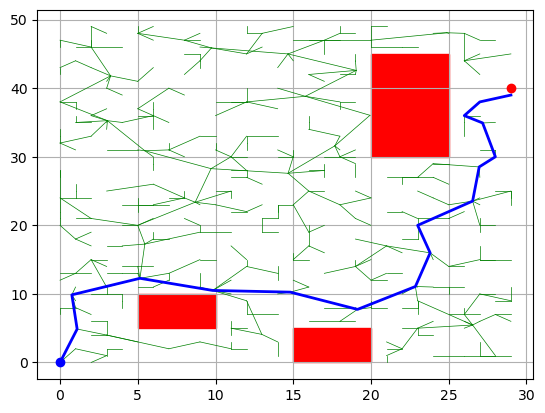

[<__main__.Node object at 0x7feb2d525300>, <__main__.Node object at 0x7feb2f230580>, <__main__.Node object at 0x7feb2f231300>, <__main__.Node object at 0x7feb2f2304c0>, <__main__.Node object at 0x7feb2f2319c0>, <__main__.Node object at 0x7feb2f230430>, <__main__.Node object at 0x7feb2f2332e0>, <__main__.Node object at 0x7feb2f3ea380>, <__main__.Node object at 0x7feb31504670>, <__main__.Node object at 0x7feb31504640>, <__main__.Node object at 0x7feb31504ee0>, <__main__.Node object at 0x7feb31507fa0>, <__main__.Node object at 0x7feb31506c80>, <__main__.Node object at 0x7feb31507130>, <__main__.Node object at 0x7feb31505150>, <__main__.Node object at 0x7feb2ccbb9a0>, <__main__.Node object at 0x7feb2d5f5810>, <__main__.Node object at 0x7feb2d5f7910>]


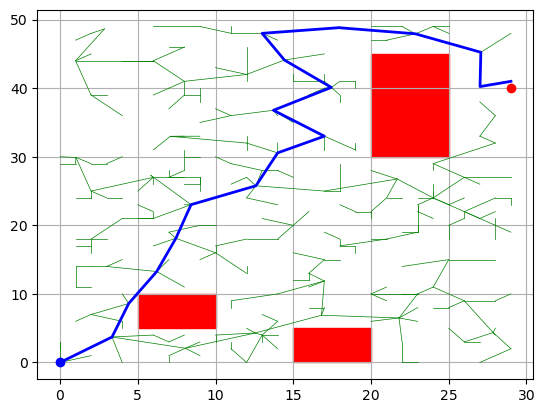

[<__main__.Node object at 0x7feb2d484850>, <__main__.Node object at 0x7feb2d08da20>, <__main__.Node object at 0x7feb2d08d390>, <__main__.Node object at 0x7feb2f3e8820>, <__main__.Node object at 0x7feb2f3eabf0>, <__main__.Node object at 0x7feb2d08d450>, <__main__.Node object at 0x7feb2f3e87f0>, <__main__.Node object at 0x7feb2f27c040>, <__main__.Node object at 0x7feb2f27ff10>, <__main__.Node object at 0x7feb2f27e170>, <__main__.Node object at 0x7feb2f27e8c0>, <__main__.Node object at 0x7feb2f27e1a0>, <__main__.Node object at 0x7feb2f27f490>, <__main__.Node object at 0x7feb2f27e650>, <__main__.Node object at 0x7feb2f27f2b0>, <__main__.Node object at 0x7feb2eeb0d60>, <__main__.Node object at 0x7feb2eeb0910>, <__main__.Node object at 0x7feb2f331d80>, <__main__.Node object at 0x7feb2f331ae0>, <__main__.Node object at 0x7feb2f205a80>]


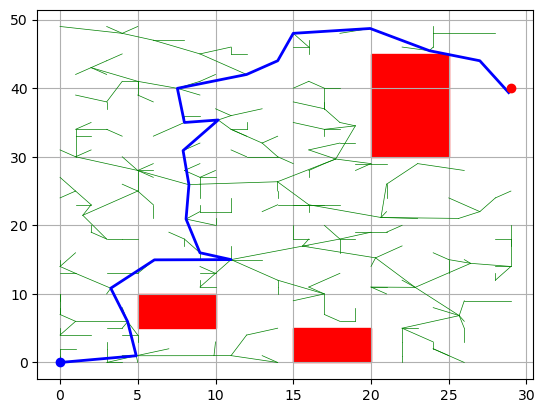

[<__main__.Node object at 0x7feb2cf3c700>, <__main__.Node object at 0x7feb2ccba9b0>, <__main__.Node object at 0x7feb2cf47430>, <__main__.Node object at 0x7feb2cf47580>, <__main__.Node object at 0x7feb2cf475b0>, <__main__.Node object at 0x7feb2cf47be0>, <__main__.Node object at 0x7feb2cf477f0>, <__main__.Node object at 0x7feb2cf47a00>, <__main__.Node object at 0x7feb31505ea0>, <__main__.Node object at 0x7feb2d270610>, <__main__.Node object at 0x7feb2d270640>, <__main__.Node object at 0x7feb2cc78fa0>, <__main__.Node object at 0x7feb2cc7ac50>, <__main__.Node object at 0x7feb2cce8100>, <__main__.Node object at 0x7feb2cce8460>, <__main__.Node object at 0x7feb2cce84c0>, <__main__.Node object at 0x7feb2ce8ed40>]


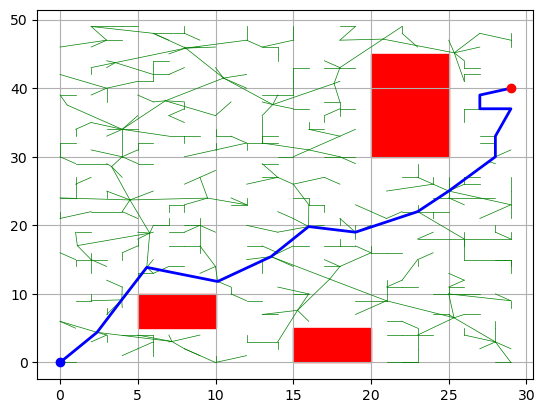

[<__main__.Node object at 0x7feb2f205780>, <__main__.Node object at 0x7feb2f205bd0>, <__main__.Node object at 0x7feb2d178a90>, <__main__.Node object at 0x7feb2d2701c0>, <__main__.Node object at 0x7feb2cf0b0a0>, <__main__.Node object at 0x7feb2cf0b100>, <__main__.Node object at 0x7feb2d5f9fc0>, <__main__.Node object at 0x7feb2d5f8040>, <__main__.Node object at 0x7feb2d5fa8c0>, <__main__.Node object at 0x7feb2d5fab60>, <__main__.Node object at 0x7feb2d5fb460>, <__main__.Node object at 0x7feb2d5fabf0>, <__main__.Node object at 0x7feb2d1a1ea0>, <__main__.Node object at 0x7feb2d1a2320>, <__main__.Node object at 0x7feb2d1a0d90>, <__main__.Node object at 0x7feb2d1a3520>, <__main__.Node object at 0x7feb2d4d1a80>]


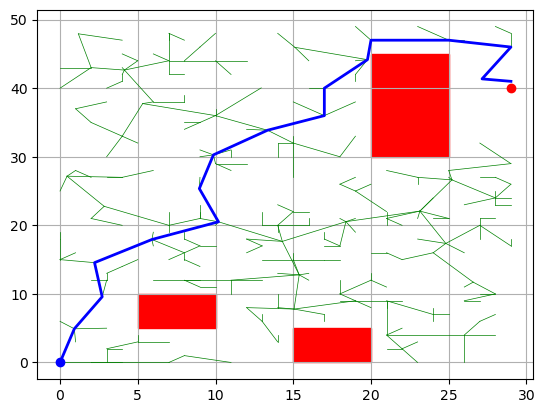

[<__main__.Node object at 0x7feb2f3c7340>, <__main__.Node object at 0x7feb2f3c7c10>, <__main__.Node object at 0x7feb2f3c6b30>, <__main__.Node object at 0x7feb2f3c6b90>, <__main__.Node object at 0x7feb2f3c7400>, <__main__.Node object at 0x7feb2f3c4a90>, <__main__.Node object at 0x7feb2f3c5840>, <__main__.Node object at 0x7feb2f3c5e10>, <__main__.Node object at 0x7feb2f0f5ab0>, <__main__.Node object at 0x7feb2f0f75b0>, <__main__.Node object at 0x7feb2f0f6bf0>, <__main__.Node object at 0x7feb2f083910>, <__main__.Node object at 0x7feb2f080400>, <__main__.Node object at 0x7feb2f082440>, <__main__.Node object at 0x7feb2f081fc0>, <__main__.Node object at 0x7feb2f0829e0>]


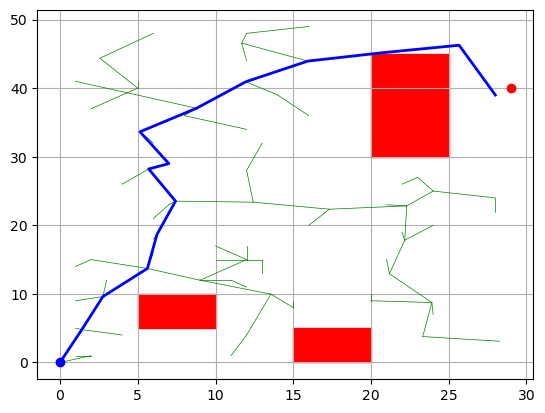

[<__main__.Node object at 0x7feb2d4d2470>, <__main__.Node object at 0x7feb2d4d2920>, <__main__.Node object at 0x7feb2d4d02b0>, <__main__.Node object at 0x7feb2d4d11b0>, <__main__.Node object at 0x7feb2d4d1450>, <__main__.Node object at 0x7feb2f26c490>, <__main__.Node object at 0x7feb2f26eb90>, <__main__.Node object at 0x7feb2f26d930>, <__main__.Node object at 0x7feb2f26e2f0>, <__main__.Node object at 0x7feb2cec7340>, <__main__.Node object at 0x7feb2cec5510>, <__main__.Node object at 0x7feb2d527190>, <__main__.Node object at 0x7feb2d5260e0>, <__main__.Node object at 0x7feb2d524a30>]


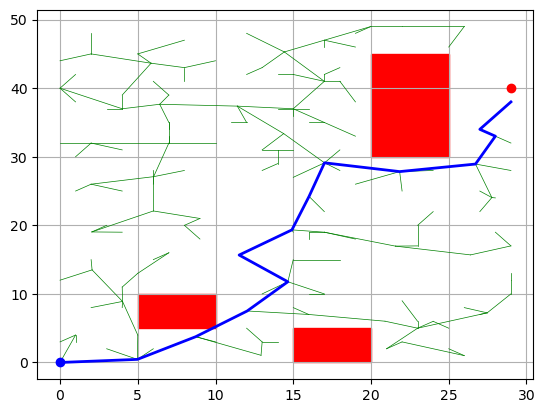

[<__main__.Node object at 0x7feb2f3c71c0>, <__main__.Node object at 0x7feb2efed780>, <__main__.Node object at 0x7feb2efef2e0>, <__main__.Node object at 0x7feb2efee710>, <__main__.Node object at 0x7feb2efedf90>, <__main__.Node object at 0x7feb2efed690>, <__main__.Node object at 0x7feb2efed870>, <__main__.Node object at 0x7feb2efec280>, <__main__.Node object at 0x7feb2efed600>, <__main__.Node object at 0x7feb2f082740>, <__main__.Node object at 0x7feb2d57ed70>, <__main__.Node object at 0x7feb2d57f1c0>, <__main__.Node object at 0x7feb2d57e140>, <__main__.Node object at 0x7feb2cce8b80>]


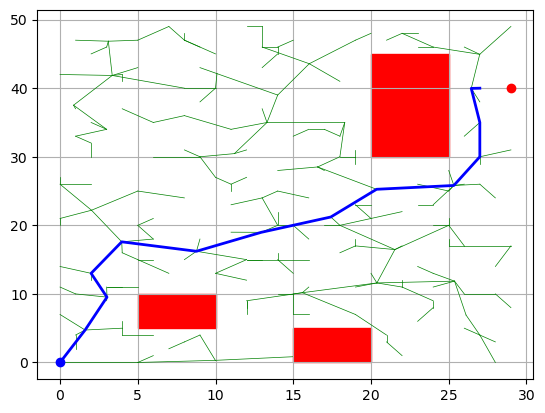

[<__main__.Node object at 0x7feb2d5f4d90>, <__main__.Node object at 0x7feb2cec79d0>, <__main__.Node object at 0x7feb2cec6b90>, <__main__.Node object at 0x7feb2cec6050>, <__main__.Node object at 0x7feb31503850>, <__main__.Node object at 0x7feb31501000>, <__main__.Node object at 0x7feb31500130>, <__main__.Node object at 0x7feb31502170>, <__main__.Node object at 0x7feb31503dc0>, <__main__.Node object at 0x7feb31513eb0>, <__main__.Node object at 0x7feb31511300>, <__main__.Node object at 0x7feb31510040>, <__main__.Node object at 0x7feb31511030>, <__main__.Node object at 0x7feb315136d0>, <__main__.Node object at 0x7feb2ce54cd0>, <__main__.Node object at 0x7feb2ce56fb0>, <__main__.Node object at 0x7feb2ce54970>, <__main__.Node object at 0x7feb2ce56590>, <__main__.Node object at 0x7feb2ce56710>]


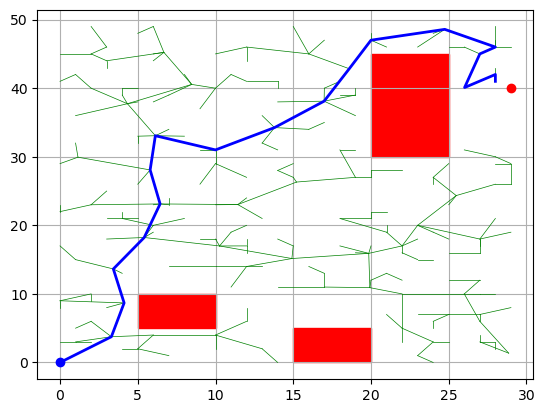

[<__main__.Node object at 0x7feb2d5f9390>, <__main__.Node object at 0x7feb2d5f8670>, <__main__.Node object at 0x7feb2d5faa40>, <__main__.Node object at 0x7feb2d5fbdc0>, <__main__.Node object at 0x7feb2d273cd0>, <__main__.Node object at 0x7feb2d2715d0>, <__main__.Node object at 0x7feb2d273280>, <__main__.Node object at 0x7feb2d57de10>, <__main__.Node object at 0x7feb2d55c5e0>, <__main__.Node object at 0x7feb2d39aaa0>, <__main__.Node object at 0x7feb2d39b8b0>, <__main__.Node object at 0x7feb2d39bd00>, <__main__.Node object at 0x7feb2d3984c0>, <__main__.Node object at 0x7feb2d39af50>, <__main__.Node object at 0x7feb2f2072b0>, <__main__.Node object at 0x7feb31504520>]


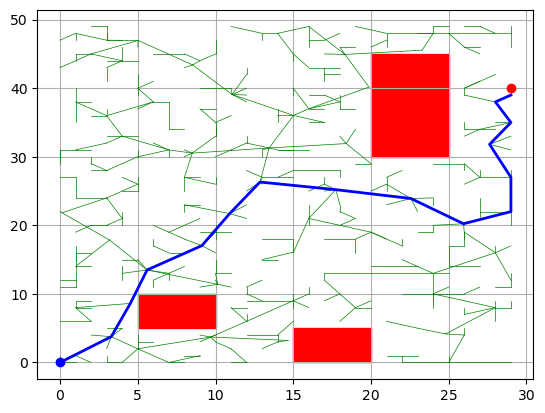

[<__main__.Node object at 0x7feb2f204a00>, <__main__.Node object at 0x7feb2d1f2110>, <__main__.Node object at 0x7feb2d1f3fa0>, <__main__.Node object at 0x7feb2d1f11b0>, <__main__.Node object at 0x7feb2d1f2bc0>, <__main__.Node object at 0x7feb2d1f3910>, <__main__.Node object at 0x7feb315119c0>, <__main__.Node object at 0x7feb2f0f6f20>, <__main__.Node object at 0x7feb2f0f7af0>, <__main__.Node object at 0x7feb2f0f62f0>, <__main__.Node object at 0x7feb2cf081c0>, <__main__.Node object at 0x7feb2ccebee0>, <__main__.Node object at 0x7feb2ccebbe0>, <__main__.Node object at 0x7feb2cceacb0>]


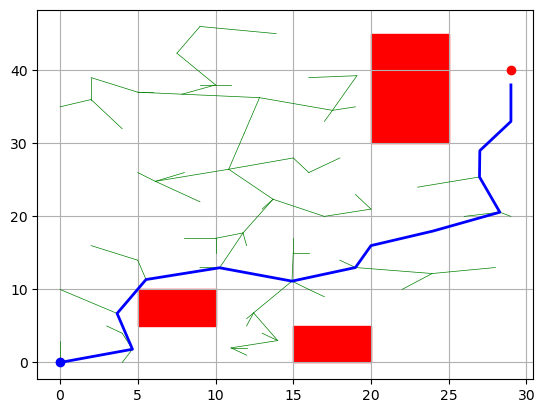

[<__main__.Node object at 0x7feb2f23d150>, <__main__.Node object at 0x7feb2f207a30>, <__main__.Node object at 0x7feb2cf27190>, <__main__.Node object at 0x7feb2f204520>, <__main__.Node object at 0x7feb2cf26c50>, <__main__.Node object at 0x7feb2cf26a70>, <__main__.Node object at 0x7feb314d5e40>, <__main__.Node object at 0x7feb2d192da0>, <__main__.Node object at 0x7feb2d191c00>, <__main__.Node object at 0x7feb31558460>, <__main__.Node object at 0x7feb3155a950>, <__main__.Node object at 0x7feb2f1d7640>, <__main__.Node object at 0x7feb2f1d7280>]


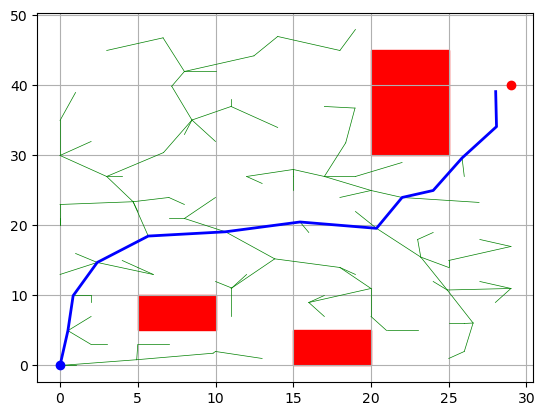

In [8]:
population = create_initial_population(population_size=50, plot_paths=True)

In [14]:
population_queue = []
for index, path in enumerate(population):
  euc_dist, F = fitness_function(path)
  population_queue.append((-F,path))
  print(population_queue)
  heapq.heapify(population_queue)
path1 = heapq.heappop(population_queue)
# print(path1[1])
print(path1[0])
plot(nodes=[], path=path1[1])

[(-0.00826406342756063, [<__main__.Node object at 0x7feb31512020>, <__main__.Node object at 0x7feb31512b00>, <__main__.Node object at 0x7feb31512bc0>, <__main__.Node object at 0x7feb31511480>, <__main__.Node object at 0x7feb315134c0>, <__main__.Node object at 0x7feb31512cb0>, <__main__.Node object at 0x7feb31512c20>, <__main__.Node object at 0x7feb31510910>, <__main__.Node object at 0x7feb31511090>, <__main__.Node object at 0x7feb315115a0>, <__main__.Node object at 0x7feb315127a0>, <__main__.Node object at 0x7feb31510c10>, <__main__.Node object at 0x7feb31503df0>, <__main__.Node object at 0x7feb315032b0>, <__main__.Node object at 0x7feb31501750>, <__main__.Node object at 0x7feb31504e20>, <__main__.Node object at 0x7feb31505c60>, <__main__.Node object at 0x7feb314d6470>])]
[(-0.00826406342756063, [<__main__.Node object at 0x7feb31512020>, <__main__.Node object at 0x7feb31512b00>, <__main__.Node object at 0x7feb31512bc0>, <__main__.Node object at 0x7feb31511480>, <__main__.Node object at

TypeError: '<' not supported between instances of 'Node' and 'Node'

In [ ]:
# if __name__ == "__main__":
#   for i in range():
#     main()

In [ ]:
# genetic_algorithm()

In [13]:
A = Node(1,2)
B = Node(1,4)
X = Node(1,6)
list = [(1,A), (2,B), (3,X)]
heapq.heapify(list)
x = heapq.heappop(list)
print(x[0])
print(x[1].y)

1
2
